In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision.io import read_image, ImageReadMode, write_video
import torchvision.transforms as T
from random import randint
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pylab as pl
from importlib import reload  

from scripts import *
from CAModel import *

In [2]:
N_CHANNELS = 16        # Number of CA state channels
TARGET_PADDING = 16    # Number of pixels used to pad the target image border
TARGET_SIZE = 40       # Size of the target emoji
IMAGE_SIZE = TARGET_PADDING+TARGET_SIZE
BATCH_SIZE = 1
N_ITERS = 50           # Iterations before applying the loss
POOL_SIZE = 1024
CELL_FIRE_RATE = 0.5

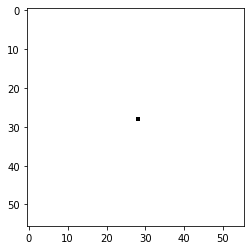

In [3]:
# Starting state
pool = SamplePool(POOL_SIZE, N_CHANNELS, IMAGE_SIZE)
imshow(pool[0][0])

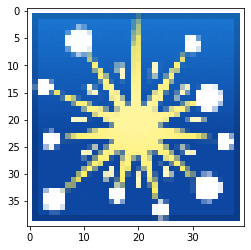

In [4]:
# Imports the target emoji
target = read_image("firework.png", ImageReadMode.RGB_ALPHA).float()
target = T.Resize((TARGET_SIZE, TARGET_SIZE))(target)
target = RGBAtoFloat(target)

imshow(target)

In [5]:
# Custom loss function
class loss_fn:
    """Custom l2 or l1 loss function"""
    def __init__(self, target, order=2):
        self.order = order
        self.target = target
        
    def __call__(self, x):
        return torch.mean(torch.abs(x[:, :4, :, :] - self.target)**self.order)

target = target.cpu()
loss_fn(pad(target, TARGET_PADDING), 1)(pool.sample(16)[0])

tensor(0.2883)

In [9]:
pool.transform(FloattoTrain)
target = FloattoTrain(target)

In [6]:
# Define the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

target = target.to(device)
model = CAModel().to(device)

In [7]:
# loads a pretrained model
model.load("not_persistent.pt")

Successfully loaded model!


In [8]:
# Make evolution video
model.makeVideo(video_size=IMAGE_SIZE, n_iters=N_ITERS*2, fps=10, rescaling=8)

/home/lettera/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1301.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [12]:
# Train the model
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = loss_fn(pad(target, TARGET_PADDING), order=2)
model.train()
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10000,20000,30000], gamma=0.4)
losses = []
for i in range(50000):
    inputs, indexes = pool.sample(BATCH_SIZE)
    inputs = inputs.to(device)
    optimizer.zero_grad()
    
    for j in range(N_ITERS+randint(-10, 10)):
        inputs = model(inputs)
    
    loss = criterion(inputs)
    loss.backward()
    optimizer.step()
    scheduler.step()
    losses.append(loss.item())

/home/lettera/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1301.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


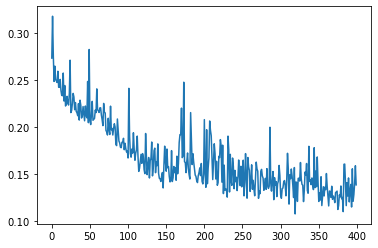

In [13]:
pl.plot(losses)

/home/lettera/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1301.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


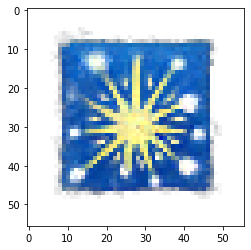

In [8]:
# Plots the learned CA
x, _ = pool.sample(1)
x = x.to(device)
x = model.evolve(x, N_ITERS)

imshow(x[0])

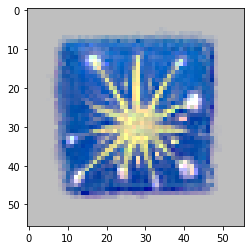

In [25]:
# Plots the learned CA
x, _ = pool.sample(1)
x = x.to(device)
x = model.evolve(x, N_ITERS+10)

imshow(TraintoFloat(x[0],-1,1))

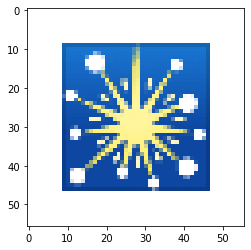

In [103]:
# Plots the true emoji
imshow(Pad(target))